In [13]:
!pip install -q -U transformers==4.53.3 huggingface-hub

# Library code, modified

MQT Q-Former from https://github.com/gordonhu608/MQT-LLaVA

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.init import trunc_normal_
import math
from functools import partial
import numpy as np
import random

def get_matry_n(num_visual_tokens):
    if num_visual_tokens == 'first_stage':
        return 729
    elif num_visual_tokens == 'second_stage':
        matry_list = range(1, 730, 4)
        return random.choice(matry_list)

    try:
        num_visual_tokens = int(num_visual_tokens)
        if 1 <= num_visual_tokens <= 729:
            return num_visual_tokens
    except (ValueError, TypeError):
        print('The num_visual_tokens is should be an integer between 1 and 729')

    raise ValueError(f"Invalid input: {num_visual_tokens}")

def get_abs_pos(abs_pos, tgt_size):
    # abs_pos: L, C
    # tgt_size: (H, W)
    # return: M, C
    src_size = int(math.sqrt(abs_pos.size(0)))
    # tgt_size = int(math.sqrt(tgt_size))
    dtype = abs_pos.dtype
    return F.interpolate(
        abs_pos.float().reshape(1, src_size, src_size, -1).permute(0, 3, 1, 2),
        size=(tgt_size[0], tgt_size[1]),
        mode="bicubic",
        align_corners=False,
    ).permute(0, 2, 3, 1).flatten(0, 2).to(dtype=dtype)


# https://github.com/facebookresearch/mae/blob/efb2a8062c206524e35e47d04501ed4f544c0ae8/util/pos_embed.py#L20
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])


    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000 ** omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


class Resampler(nn.Module):
    """
    A 2D perceiver-resampler network with one cross attention layers by
        (grid_size**2) learnable queries and 2d sincos pos_emb
    Outputs:
        A tensor with the shape of (grid_size**2, embed_dim)
    """

    def __init__(
            self,
            grid_size,
            embed_dim,
            num_heads,
            kv_dim=None,
            norm_layer=partial(nn.LayerNorm, eps=1e-6)
    ):
        super().__init__()
        self.num_queries = grid_size ** 2
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.pos_embed = nn.Parameter(
            torch.from_numpy(get_2d_sincos_pos_embed(kv_dim, grid_size)).to(torch.bfloat16)
        ).requires_grad_(False)

        self.query = nn.Parameter(torch.zeros(self.num_queries, kv_dim)).to(torch.bfloat16)
        trunc_normal_(self.query, std=.02)

        self.attn = nn.MultiheadAttention(kv_dim, num_heads).to(device = "cuda:0", dtype=torch.bfloat16)

        self.ln_q = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.bfloat16)
        self.ln_k = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.bfloat16)
        self.ln_v = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.bfloat16)

        # self.ln_post = norm_layer(kv_dim)
        self.proj = nn.Parameter((embed_dim ** -0.5) * torch.randn(kv_dim, embed_dim)).to(device="cuda:0", dtype=torch.bfloat16)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x, num_visual_tokens=256, tgt_size=(24,24), attn_mask=None):
        pos_embed = get_abs_pos(self.pos_embed, tgt_size)

        x = x.permute(1, 0, 2)  # x: (seq_len, batch_size, dim)
        B = x.shape[1]  # true batch size


        matry_n = get_matry_n(num_visual_tokens)
        q = self.query[:matry_n]  # (matry_n, dim)
        q = self._repeat(q, B)    # (matry_n, B, dim)

        k = self._repeat(pos_embed, B).to(device = "cuda:0", dtype=torch.bfloat16)
        v = x
        q= q.to(device = "cuda:0")
        # self.pos_embed = self.pos_embed.to(device = "cuda:0")
        # print(q.dtype)
        # print(k.dtype)
        # print(v.dtype)
        # print (self.pos_embed.dtype)
        q = self.ln_q(q + self.pos_embed[:matry_n].unsqueeze(1).to(device = "cuda:0")).to(device = x.device ,dtype=torch.bfloat16)
        k = self.ln_k(k).to(device = x.device ,dtype=torch.bfloat16)
        v = self.ln_v(v).to(device = x.device ,dtype=torch.bfloat16)

        out = self.attn(q, k, v, attn_mask=attn_mask)[0]  # (matry_n, B, dim)


        x = out.permute(1, 0, 2)

        x = x @ self.proj
        # print(x.shape)
        return x

    def _repeat(self, query, N: int):
        return query.unsqueeze(1).repeat(1, N, 1)

In [2]:
class MultiResampler(nn.Module):
    """
    experimental multi-resampler

    Args:
        num_resamplers:int = number of resamplers(qformers)

    Outputs:
        A tensor with the shape of (grid_size**2, embed_dim)
    """

    def __init__(
            self,
            grid_size,
            embed_dim,
            num_heads,
            num_resamplers,
            kv_dim=None,
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.resamplers = [Resampler(grid_size, embed_dim, num_heads, kv_dim, norm_layer) for _ in range(num_resamplers)]

    def _init_weights(self, m):
        for i in  range(len(self.resamplers)):
            self.resamplers[i]._init_weights(m)

    def forward(self, x: list, num_visual_tokens=256, tgt_size=(27,27), attn_mask=None):
        assert len(x) == len(self.resamplers)

        num_vt_each = num_visual_tokens//len(self.resamplers)
        outs = []
        for i in range(len(self.resamplers)):
            outs.append(self.resamplers[i].forward(x[i], num_vt_each, tgt_size))
        # concat = torch.cat(outs, dim=1)
        # print("multi resampler:", outs[0].shape)
        return outs

# Q-Former

In [3]:
qformer_config = {
    "grid_size": 27,
    "embed_dim": 1152,
    "num_heads": 64,
    "num_resamplers": 6,
    "kv_dim": 1152
}

In [20]:
import torch
import torch.nn as nn
from transformers import ViTModel, AutoImageProcessor
from transformers.modeling_outputs import BaseModelOutput
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from torchvision.transforms import functional as F_transforms
from huggingface_hub import PyTorchModelHubMixin

class MultiCropVisionEncoder(nn.Module, PyTorchModelHubMixin):
    def __init__(self, qformer_config, vision_tower):
        super().__init__()
        self.num_resamplers = qformer_config["num_resamplers"]
        self.embed_dim = qformer_config["embed_dim"]
        self.grid_size = qformer_config["grid_size"]

        self.vision_tower = vision_tower
        vision_hidden_size = self.vision_tower.config.hidden_size
        self.vision_tower_image_size = self.vision_tower.config.image_size

        self.vision_proj = nn.Linear(vision_hidden_size, self.embed_dim)

        self.multi_resampler = MultiResampler(
            grid_size=qformer_config["grid_size"],
            embed_dim=qformer_config["embed_dim"],
            num_heads=qformer_config["num_heads"],
            num_resamplers=qformer_config["num_resamplers"],
            kv_dim=qformer_config["kv_dim"],
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
        )

    def forward(self, pixel_values, patch_attention_mask=None):
        pixel_values = pixel_values.to(torch.bfloat16)
        b4, c, h, w = pixel_values.shape
        assert b4 % self.num_resamplers == 0, "Batch size must be divisible by number of resamplers"
        batch_size = b4 // self.num_resamplers

        # image = np.transpose(pixel_values[0].cpu().numpy(), (1, 2, 0))
        # plt.imshow(image / 255.0)
        # plt.show()

        pixel_values = pixel_values.view(batch_size, self.num_resamplers, c, h, w)
        patch_embeddings_list = []
        for i in range(self.num_resamplers):
            sub_batch = pixel_values[:, i, :, :, :]

            resized_sub_batch = F_transforms.resize(sub_batch, size=(432, 432))


            vision_outputs = self.vision_tower(pixel_values=resized_sub_batch, interpolate_pos_encoding=True)
            embeddings = vision_outputs.last_hidden_state

            embeddings = embeddings.to(torch.bfloat16)

            embeddings = embeddings[:, 1:, :]
            embeddings = self.vision_proj(embeddings)

            patch_embeddings_list.append(embeddings)


        out = self.multi_resampler(patch_embeddings_list, num_visual_tokens=self.grid_size**2 * self.num_resamplers)

        stacked = torch.stack(out, dim=1)
        out = stacked.view(-1, stacked.shape[-2], stacked.shape[-1])
        out = out.to(device=pixel_values.device,dtype=torch.bfloat16)

        # out = out.view(batch_size * self.num_resamplers, self.grid_size**2, self.embed_dim).to(
        #     device=pixel_values.device,
        #     dtype=torch.bfloat16
        # )
        return BaseModelOutput(last_hidden_state=out)

## Test Vision Encoder

In [5]:
vision_tower = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device= "cuda:0", dtype=torch.bfloat16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [21]:
student = MultiCropVisionEncoder(qformer_config, vision_tower)
student = student.to(device="cuda", dtype=torch.bfloat16)

In [22]:
dummy_image = torch.randn(6, 3, 384, 384).to(device="cuda", dtype=torch.bfloat16)
output = student(dummy_image)
print(output.last_hidden_state.shape)

torch.Size([6, 729, 1152])


In [8]:
sum(p.numel() for p in student.parameters() if p.requires_grad)

87275136

In [9]:
sum(p.numel() for p in vision_tower.parameters() if p.requires_grad)

86389248

# load dataset

In [36]:
from huggingface_hub import hf_hub_download
import torch
ds_repo_id = "ArianFiroozi/Nuscenes-Knowledge-Transfer"

all_samples = []
path = hf_hub_download(
    repo_id=ds_repo_id,
    filename=f"batches/batch_{1}.pt",
    repo_type="dataset"
)
all_samples.extend(torch.load(path))

batch_1.pt:   0%|          | 0.00/7.69G [00:00<?, ?B/s]

In [48]:
all_samples[0]['data'].shape

torch.Size([6, 3, 384, 384])

# knowledge transfer to vision model

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

in_channels = 3
out_channels = 1
input_shape = (3, 384, 384)
output_shape = (1, 729, 1152)

epochs = 3
batch_size = 6
num_samples = 500
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
class KTDataset(Dataset):
    def __init__(self, n=None):
        self.n = n if n!=None else len(all_samples)
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        return all_samples[idx]['data'], all_samples[idx]['label']

In [57]:
for param in student.vision_tower.parameters():
    param.requires_grad = False

In [58]:
sum(p.numel() for p in student.parameters() if p.requires_grad)

885888

In [68]:
dataset = KTDataset(10)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

optimizer = torch.optim.Adam(student.parameters(), lr=lr)
criterion = nn.MSELoss()

losses = []

for epoch in range(epochs):
    student.train()
    total_loss = 0.0

    for data, label in loader:
        data = data.view(6, 3, 384, 384)
        data = data.to("cuda", dtype=torch.bfloat16)
        label = label.to("cuda", dtype=torch.bfloat16)

        student_out = student(data)
        loss = criterion(student_out.last_hidden_state, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)

    epoch_loss = total_loss / len(dataset)
    losses.append(epoch_loss)

    print(f"ep {epoch+1}/{epochs}, student loss: {epoch_loss:.6f}")

ep 1/3, student loss: 8.538281
ep 2/3, student loss: 6.733594
ep 3/3, student loss: 4.901953


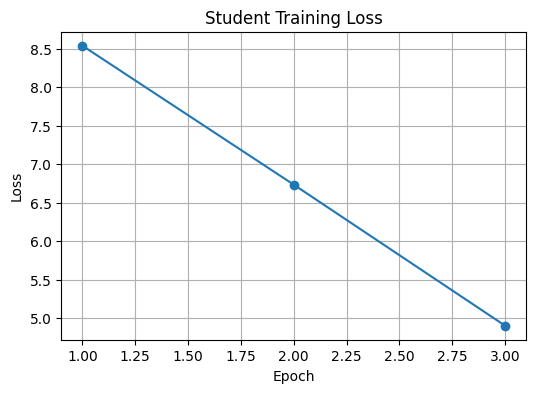

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Student Training Loss")
plt.grid(True)
plt.show()

# huggingface push

In [70]:
from huggingface_hub import notebook_login
notebook_login()
repo_id = "ArianFiroozi/SmolDriverVision"

In [71]:
student.push_to_hub(repo_id)

model.safetensors:   0%|          | 0.00/175M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ArianFiroozi/SmolDriverVision/commit/82ab9adc4f998774013b5c9fe92caea06af29425', commit_message='Push model using huggingface_hub.', commit_description='', oid='82ab9adc4f998774013b5c9fe92caea06af29425', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ArianFiroozi/SmolDriverVision', endpoint='https://huggingface.co', repo_type='model', repo_id='ArianFiroozi/SmolDriverVision'), pr_revision=None, pr_num=None)

## load

In [32]:
loaded_student = MultiCropVisionEncoder.from_pretrained(repo_id, vision_tower = vision_tower)

model.safetensors:   0%|          | 0.00/175M [00:00<?, ?B/s]

In [34]:
loaded_student=loaded_student.to("cuda", torch.bfloat16)

In [35]:
loaded_student.eval()
with torch.no_grad():
    output_loaded = loaded_student(dummy_image)

print(output_loaded.last_hidden_state.shape)

torch.Size([6, 729, 1152])
